In [1]:
from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
from hnn_core import MPIBackend

%matplotlib inline

In [2]:
# load participant data 
df = pd.read_csv('GrandAvgTEPSEP_TMS100_4hnn.txt', sep = ' ')
data = [df['Time'].tolist(), df['Dipole'].tolist()]

In [164]:
# load params from original param file
fparams = "param_files/TEP_from_def_Liz_2newInputs_optimized_TMS100.param"
params = read_params(fparams)

print(params)

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [165]:
# scale down the evdist_2 drives 
evdist_2_scalars = [0.2, 0.3, 0.4, 0.5]

params_list = [deepcopy(params) for _ in range(len(evdist_2_scalars))]

for params, scalar in zip(params_list, evdist_2_scalars):
    for param in params['gbar_evdist_1*']:
        params[param] = scalar * params[param]
        
    
print(params_list[0]['gbar_evdist_1*'])
print(params_list[1]['gbar_evdist_1*'])

{
    "gbar_evdist_1_L2Basket_ampa": 0.0558298,
    "gbar_evdist_1_L2Basket_nmda": 0.0135238,
    "gbar_evdist_1_L2Pyr_ampa": 0.0012636000000000001,
    "gbar_evdist_1_L2Pyr_nmda": 0.006053200000000001,
    "gbar_evdist_1_L5Pyr_ampa": 0.08147100000000002,
    "gbar_evdist_1_L5Pyr_nmda": 0.21034160000000002
}
{
    "gbar_evdist_1_L2Basket_ampa": 0.08374469999999999,
    "gbar_evdist_1_L2Basket_nmda": 0.0202857,
    "gbar_evdist_1_L2Pyr_ampa": 0.0018953999999999998,
    "gbar_evdist_1_L2Pyr_nmda": 0.0090798,
    "gbar_evdist_1_L5Pyr_ampa": 0.1222065,
    "gbar_evdist_1_L5Pyr_nmda": 0.3155124
}


In [166]:
evdist_2_nets = [calcium_model(params=params, add_drives_from_params=True) for params in params_list]

In [167]:
for net in evdist_2_nets:
    print(net.external_drives)
    print("_----------")

{'evdist1': <External drive 'evdist1'
drive class: evoked
target location: distal
target cell types: {'L2_basket', 'L2_pyramidal', 'L5_pyramidal'}
number of drive cells: 235
cell-specific: True
dynamic parameters:
	mu: 55.0042
	sigma: 4.946888
	numspikes: 1>, 'evdist2': <External drive 'evdist2'
drive class: evoked
target location: distal
target cell types: {'L2_basket', 'L2_pyramidal', 'L5_pyramidal'}
number of drive cells: 235
cell-specific: True
dynamic parameters:
	mu: 0.528485
	sigma: 1.434398
	numspikes: 1>, 'evdist3': <External drive 'evdist3'
drive class: evoked
target location: distal
target cell types: {'L2_basket', 'L2_pyramidal', 'L5_pyramidal'}
number of drive cells: 235
cell-specific: True
dynamic parameters:
	mu: 170
	sigma: 15
	numspikes: 1>, 'evdist4': <External drive 'evdist4'
drive class: evoked
target location: distal
target cell types: {'L2_basket', 'L2_pyramidal', 'L5_pyramidal'}
number of drive cells: 235
cell-specific: True
dynamic parameters:
	mu: 163.10259
	si

In [168]:
with MPIBackend(n_procs=2, mpi_cmd='mpiexec'):
    evdist_2_dpls_list = [simulate_dipole(net, tstop=params["tstop"], n_trials=2) for net in evdist_2_nets]
    # evdist_2_dpls_list = [simulate_dipole(net, tstop=50, n_trials=2) for net in evdist_2_nets]

MPI will run 2 trial(s) sequentially by distributing network neurons over 2 processes.
numprocs=2
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
T

In [169]:
# scale and smooth original dipoles
window_len = 30 # ms
scaling_factor = 1
dpl_smoothed_list = [deepcopy(dpl) for dpl in evdist_2_dpls_list]
for dpl in dpl_smoothed_list:
    for dpl_trial in dpl:
        dpl_trial.smooth(window_len).scale(scaling_factor)

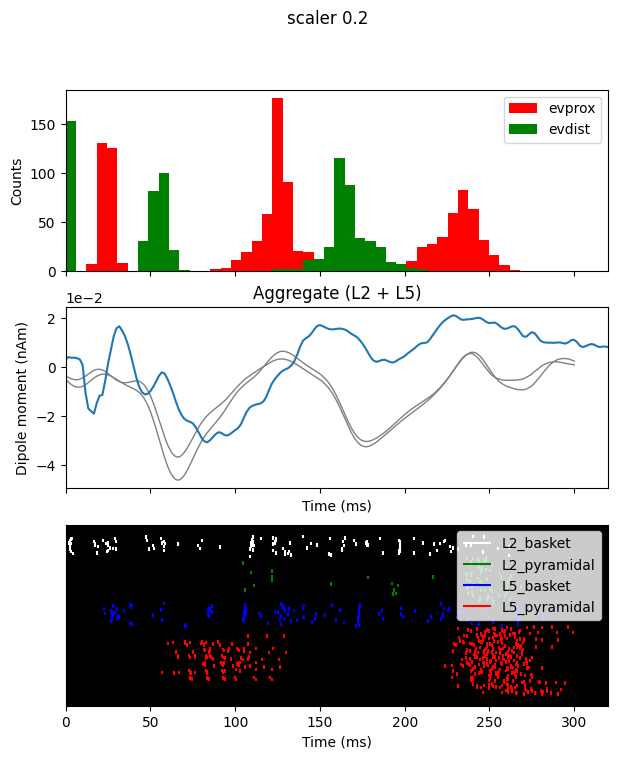

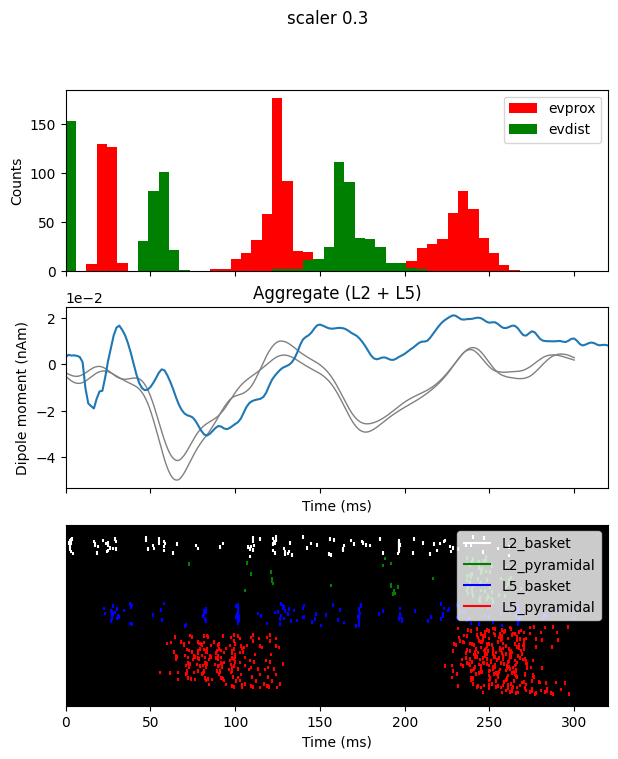

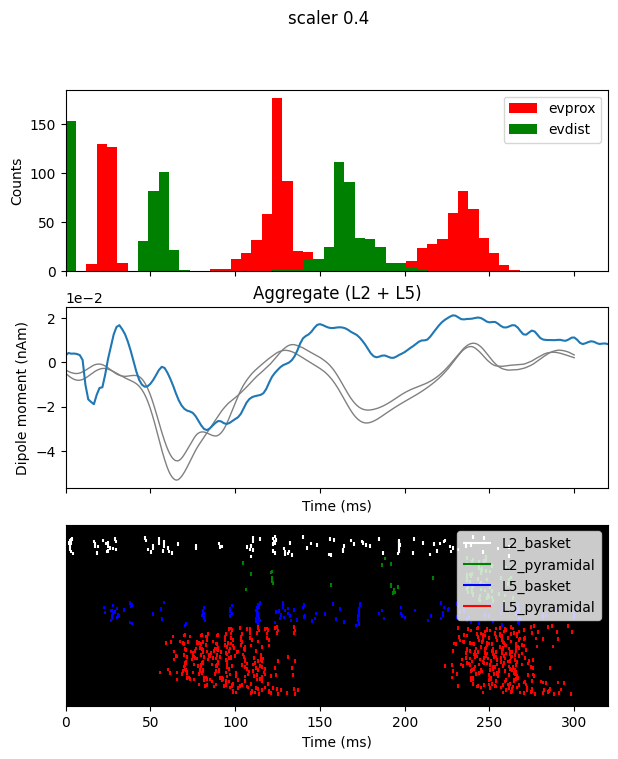

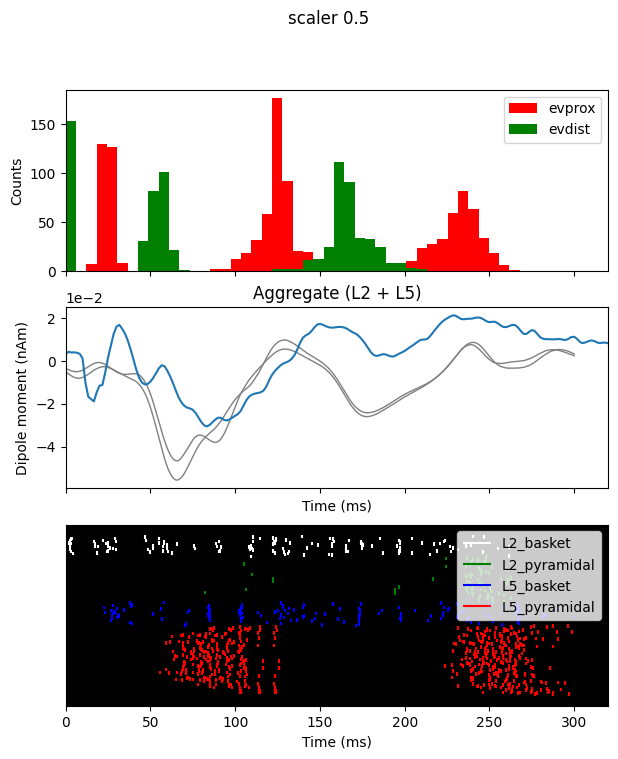

In [170]:
for i in range(len(dpl_smoothed_list)):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7,8))

    evdist_2_nets[i].cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)

    plot_dipole(dpl_smoothed_list[i], ax = axes[1], layer='agg', show=False)
    axes[1].plot(data[0], np.array(data[1])*5)
    axes[1].set_xlim(0,320)

    evdist_2_nets[i].cell_response.plot_spikes_raster(ax=axes[2], trial_idx=1, show=False)

    fig.suptitle(f'scaler {evdist_2_scalars[i]}')



<h2>Increase prox1</h2>

In [171]:
# Take the param file with 0.2 * evdist1
evdist1_set_params = deepcopy(params_list[0])

In [172]:
# scale up the prox_1 drives 
prox_1_scalars = [1e1, 1e2, 1e3, 1e4]
# prox_1_scalars=[10]

prox_params_list = [deepcopy(evdist1_set_params) for _ in range(len(prox_1_scalars))]

for params, scalar in zip(prox_params_list, prox_1_scalars):
    for param in params['gbar_evprox_1*']:
        params[param] = scalar * params[param]
        
    
print(prox_params_list[0]['gbar_evprox_1*'])

{
    "gbar_evprox_1_L2Basket_ampa": 1.59388,
    "gbar_evprox_1_L2Basket_nmda": 0.0,
    "gbar_evprox_1_L2Pyr_ampa": 0.08893,
    "gbar_evprox_1_L2Pyr_nmda": 0.0,
    "gbar_evprox_1_L5Basket_ampa": 3.02977,
    "gbar_evprox_1_L5Basket_nmda": 0.0,
    "gbar_evprox_1_L5Pyr_ampa": 0.0036499999999999996,
    "gbar_evprox_1_L5Pyr_nmda": 0.0
}


In [173]:
# scale down first distal drive, note that evdist_2 in the param file is actually the first distal drive at 0.5ms

# print(prox_params_list[0]['gbar_evdist_2*'])

# dist_1_scalars = [1e-1, 1e-1, 1e-1, 1e-1]

# for params, scalar in zip(prox_params_list, dist_1_scalars):
#     for param in params['gbar_evdist_2*']:
#         params[param] = scalar * params[param]
        
    
# print(prox_params_list[0]['gbar_evdist_2*'])

In [174]:
prox_1_nets = [calcium_model(params=params, add_drives_from_params=True) for params in prox_params_list]

In [175]:
with MPIBackend(n_procs=2, mpi_cmd='mpiexec'):
    prox_1_dpls_list = [simulate_dipole(net, tstop=params["tstop"], n_trials=2) for net in prox_1_nets]

MPI will run 2 trial(s) sequentially by distributing network neurons over 2 processes.
numprocs=2
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
T

In [176]:
# scale and smooth original dipoles
def scale_and_smooth(dpls_list, window_len = 10, scaling_factor = 1):
    dpl_smoothed_list = [deepcopy(dpl) for dpl in dpls_list]
    for dpl in dpl_smoothed_list:
        for dpl_trial in dpl:
            dpl_trial.smooth(window_len).scale(scaling_factor)
    return dpl_smoothed_list

In [177]:
prox_dpl_smoothed_list = scale_and_smooth(prox_1_dpls_list)

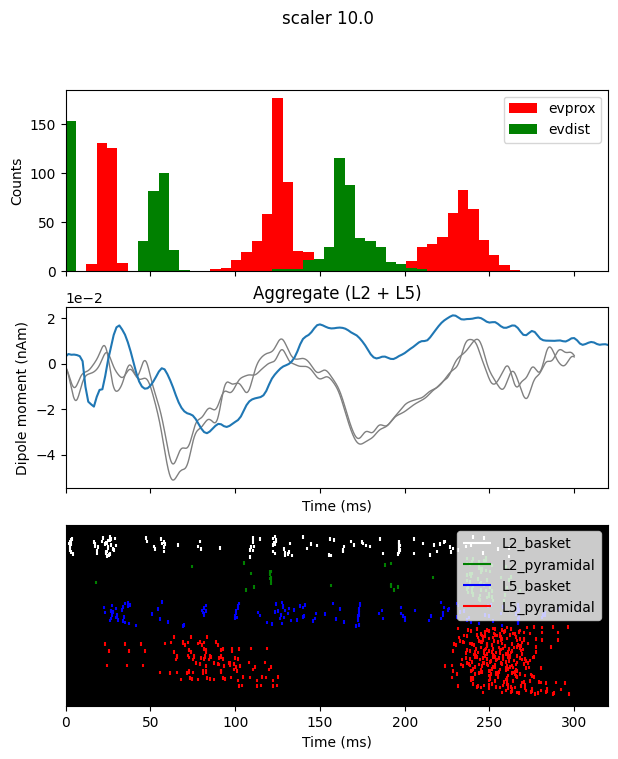

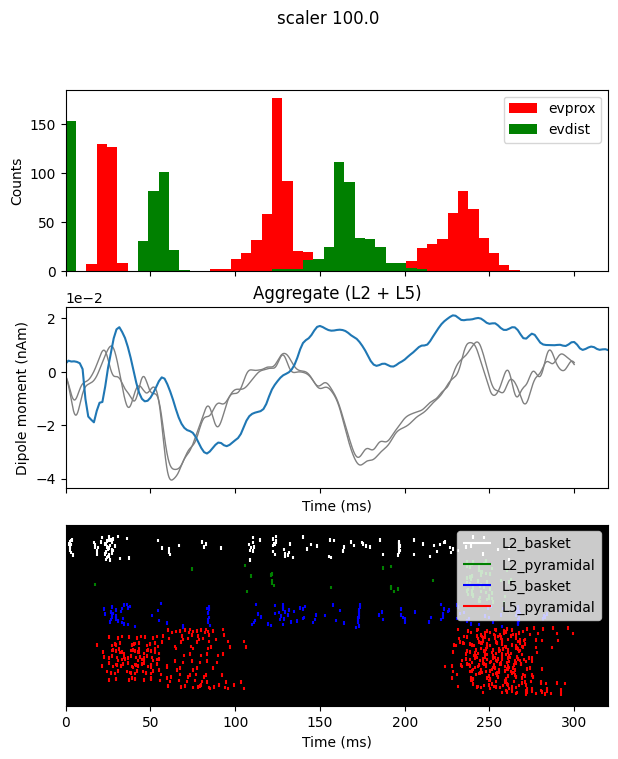

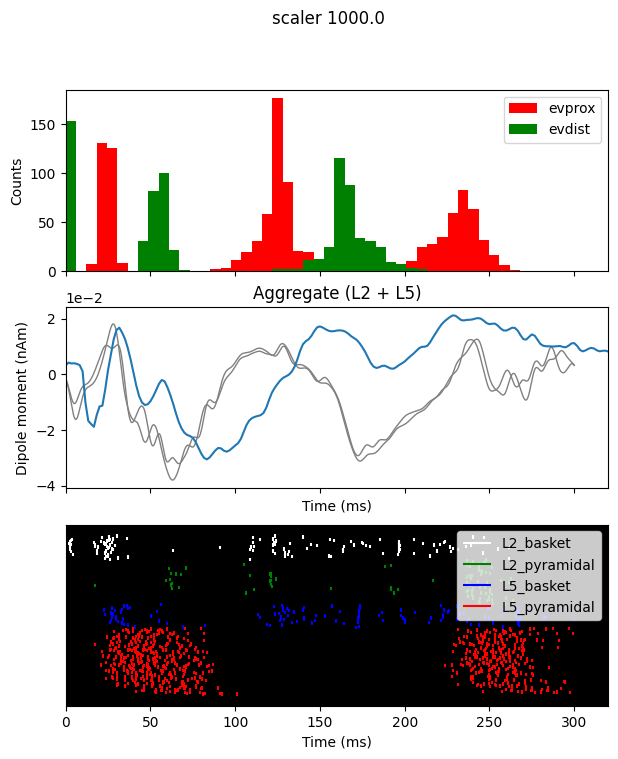

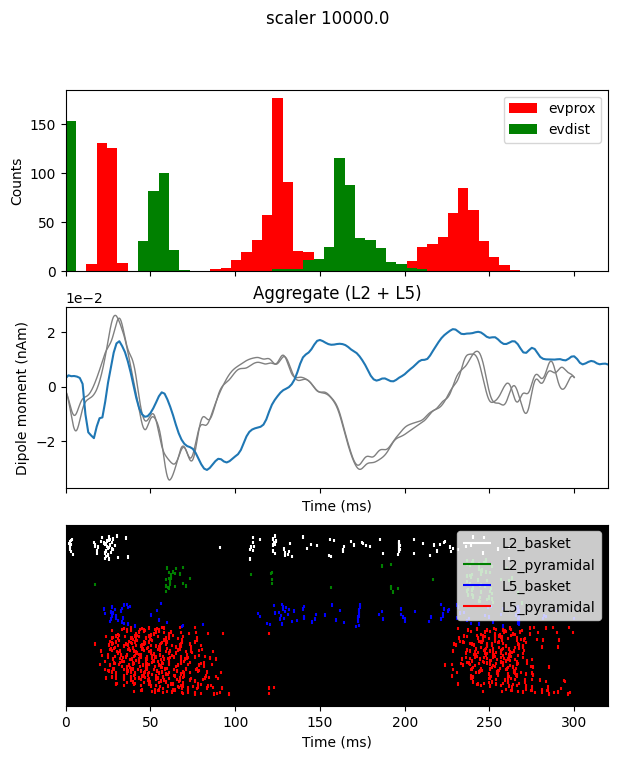

In [178]:
for i in range(len(prox_dpl_smoothed_list)):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7,8))

    prox_1_nets[i].cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)

    plot_dipole(prox_dpl_smoothed_list[i], ax = axes[1], layer='agg', show=False)
    axes[1].plot(data[0], np.array(data[1])*5)
    axes[1].set_xlim(0,320)

    prox_1_nets[i].cell_response.plot_spikes_raster(ax=axes[2], trial_idx=1, show=False)

    fig.suptitle(f'scaler {prox_1_scalars[i]}')


<h1>Move dist1, dist2, and prox2 later</h1>

In [189]:
prox1dist2_set_params = deepcopy(prox_params_list[2])

In [190]:
# make a list documenting all three changes to params
time_change_params_list = []

In [191]:
# move dist1 10 ms later
dist1_time_move = 10

print(prox1dist2_set_params['t_evdist_2'])
prox1dist2_set_params['t_evdist_2'] += dist1_time_move
print(prox1dist2_set_params['t_evdist_2'])

time_change_params_list.append(deepcopy(prox1dist2_set_params))

0.528485
10.528485


In [192]:
# move prox1 5 ms later
prox1_time_move = 5

print(prox1dist2_set_params['t_evprox_1'])
prox1dist2_set_params['t_evprox_1'] += prox1_time_move
print(prox1dist2_set_params['t_evprox_1'])

time_change_params_list.append(deepcopy(prox1dist2_set_params))

24.472788
29.472788


In [193]:
# move dist2 20 ms later
dist2_time_move = 20

print(prox1dist2_set_params['t_evdist_1'])
prox1dist2_set_params['t_evdist_1'] += dist2_time_move 
print(prox1dist2_set_params['t_evdist_1'])

time_change_params_list.append(deepcopy(prox1dist2_set_params))

55.0042
75.0042


In [194]:
time_change_nets = [calcium_model(params=params, add_drives_from_params=True) for params in time_change_params_list]

In [195]:
with MPIBackend(n_procs=2, mpi_cmd='mpiexec'):
    time_change_dpls_list = [simulate_dipole(net, tstop=params["tstop"], n_trials=2) for net in time_change_nets]

MPI will run 2 trial(s) sequentially by distributing network neurons over 2 processes.
numprocs=2
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
T

In [196]:
time_change_dpl_smoothed_list = scale_and_smooth(time_change_dpls_list)

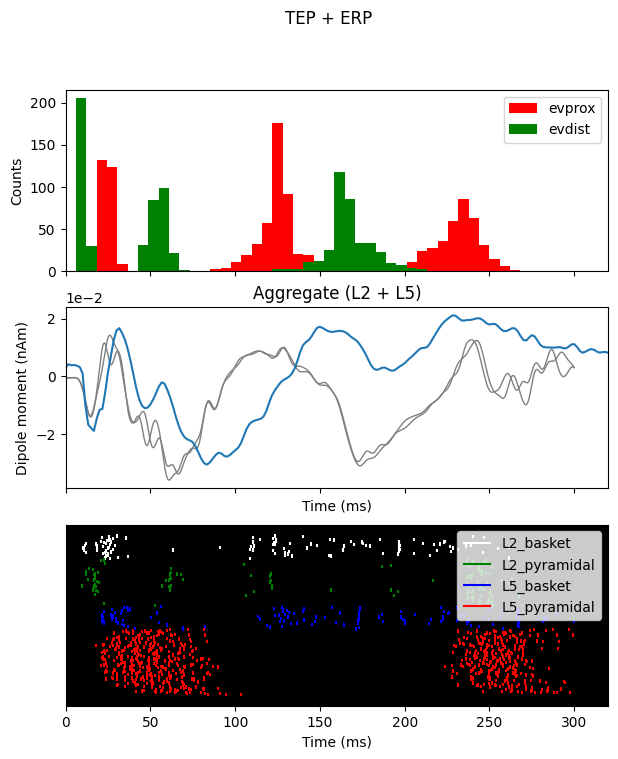

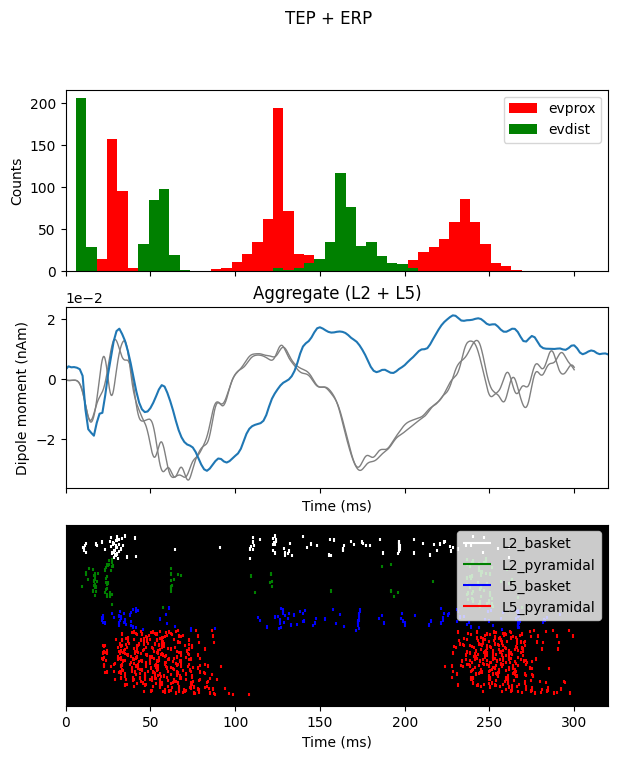

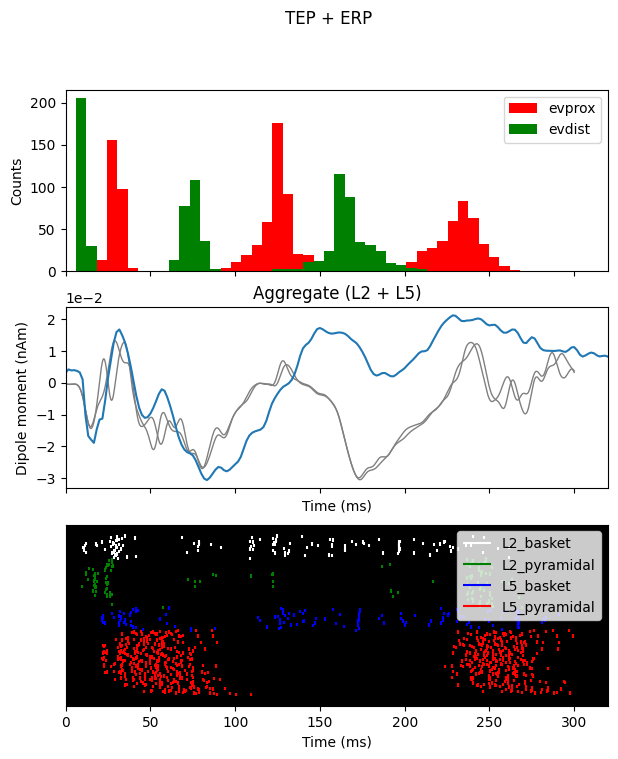

In [198]:
time_change_names = ["dist1", "prox1", "dist2"]
time_change_values = [dist1_time_move, prox1_time_move, dist2_time_move]

for i in range(len(time_change_dpl_smoothed_list)):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7,8))

    time_change_nets[i].cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)

    plot_dipole(time_change_dpl_smoothed_list[i], ax = axes[1], layer='agg', show=False)
    axes[1].plot(data[0], np.array(data[1])*5)
    axes[1].set_xlim(0,320)

    time_change_nets[i].cell_response.plot_spikes_raster(ax=axes[2], trial_idx=1, show=False)

    # fig.suptitle(f'{time_change_names[i]} {time_change_values[i]}')
    fig.suptitle('TEP + ERP')


dist2 * 10 

In [120]:
restore_dist2 = deepcopy(time_change_params_list[1])

In [ ]:
# scale up the evdist_2 drives 
evdist_2_scalars = [2, 5]

params_list = [deepcopy(restore_dist2) for _ in range(len(evdist_2_scalars))]

for params, scalar in zip(params_list, evdist_2_scalars):
    for param in params['gbar_evdist_1*']:
        params[param] = scalar * params[param]
        
    
print(params_list[0]['gbar_evdist_1*'])
print(params_list[1]['gbar_evdist_1*'])

{
    "gbar_evdist_1_L2Basket_ampa": 0.1116596,
    "gbar_evdist_1_L2Basket_nmda": 0.0270476,
    "gbar_evdist_1_L2Pyr_ampa": 0.0025272000000000003,
    "gbar_evdist_1_L2Pyr_nmda": 0.012106400000000002,
    "gbar_evdist_1_L5Pyr_ampa": 0.16294200000000003,
    "gbar_evdist_1_L5Pyr_nmda": 0.42068320000000003
}
{
    "gbar_evdist_1_L2Basket_ampa": 0.279149,
    "gbar_evdist_1_L2Basket_nmda": 0.067619,
    "gbar_evdist_1_L2Pyr_ampa": 0.006318000000000001,
    "gbar_evdist_1_L2Pyr_nmda": 0.030266000000000005,
    "gbar_evdist_1_L5Pyr_ampa": 0.4073550000000001,
    "gbar_evdist_1_L5Pyr_nmda": 1.051708
}


In [122]:
increase_evdist_2_nets = [calcium_model(params=params, add_drives_from_params=True) for params in params_list]

In [123]:
with MPIBackend(n_procs=2, mpi_cmd='mpiexec'):
    increase_evdist2_dpls_list = [simulate_dipole(net, tstop=params["tstop"], n_trials=2) for net in increase_evdist_2_nets]

MPI will run 2 trial(s) sequentially by distributing network neurons over 2 processes.
numprocs=2
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
T

In [124]:
increase_evdist2_dpl_smoothed_list = scale_and_smooth(increase_evdist2_dpls_list)

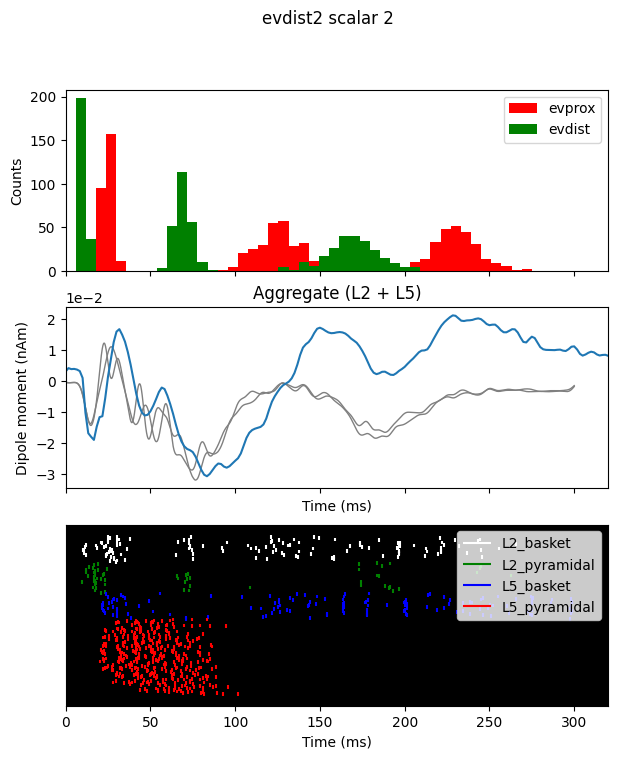

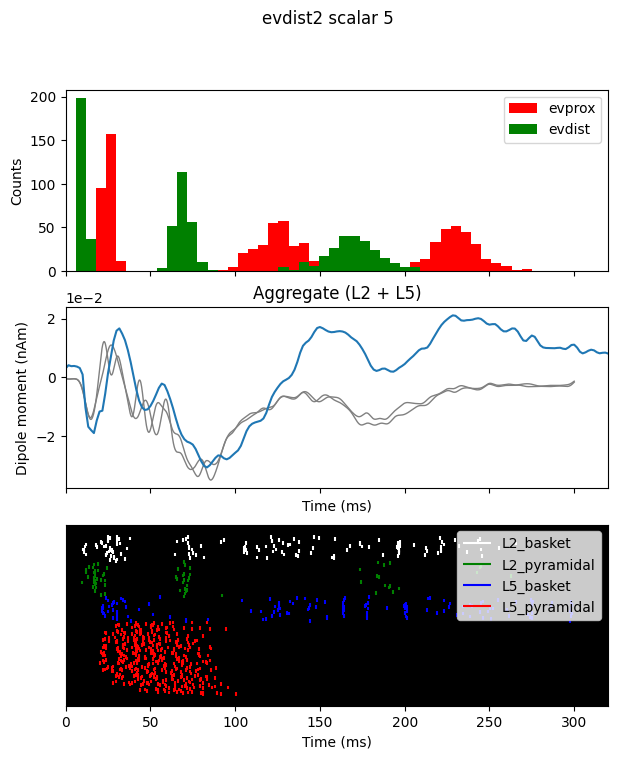

In [125]:
for i in range(len(increase_evdist2_dpl_smoothed_list)):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7,8))

    increase_evdist_2_nets[i].cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)

    plot_dipole(increase_evdist2_dpl_smoothed_list[i], ax = axes[1], layer='agg', show=False)
    axes[1].plot(data[0], np.array(data[1])*5)
    axes[1].set_xlim(0,320)

    increase_evdist_2_nets[i].cell_response.plot_spikes_raster(ax=axes[2], trial_idx=1, show=False)

    fig.suptitle(f'evdist2 scalar {evdist_2_scalars[i]}')

<h1> add SEP </h1>

In [159]:
def add_SEP(net):

    #distal evoked drive
    weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                   'L5_pyramidal': 0.142300}
    weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                   'L5_pyramidal': 0.080074}
    synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
    net.add_evoked_drive(
        'evdist4', mu=163.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
        weights_nmda=weights_nmda_d1, location='distal',
        synaptic_delays=synaptic_delays_d1, event_seed=274)
    
    #add proximal drive 1
    weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                   'L5_basket': 0.19934, 'L5_pyramidal': 0.00865}
    synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                            'L5_basket': 1., 'L5_pyramidal': 1.}
    net.add_evoked_drive(
        'evprox4', mu=126.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
        weights_nmda=None, location='proximal',
        synaptic_delays=synaptic_delays_prox, event_seed=544)

    # add proximal drive 2
    weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                    'L5_basket': 0.008958, 'L5_pyramidal': 0.684013}
    net.add_evoked_drive(
        'evprox5', mu=237.12, sigma=8.33, numspikes=1,
        weights_ampa=weights_ampa_p2, location='proximal',
        synaptic_delays=synaptic_delays_prox, event_seed=814)

In [160]:
added_SEP_net = add_SEP(deepcopy(increase_evdist_2_nets[1]))

In [162]:
with MPIBackend(n_procs=2, mpi_cmd='mpiexec'):
    add_SEP_dpl =  simulate_dipole(added_SEP_net, tstop=params_list[1]['tstop'], n_trials=2)

AttributeError: 'NoneType' object has no attribute 'connectivity'

In [151]:
increase_prox2 = deepcopy(params_list[1])

In [152]:
# scale up the prox_2 drives 
prox2_scalars = [200, 300, 400]

prox2_increased_param_list = [deepcopy(increase_prox2) for _ in range(len(prox2_scalars))]

for params, scalar in zip(prox2_increased_param_list, prox2_scalars):
    for param in params['gbar_evprox_3*']:
        params[param] = scalar * params[param]        
    
print(prox2_increased_param_list[0]['gbar_evprox_3*'])
print(prox2_increased_param_list[1]['gbar_evprox_3*'])

{
    "gbar_evprox_3_L2Basket_ampa": 18.0,
    "gbar_evprox_3_L2Basket_nmda": 50.0,
    "gbar_evprox_3_L2Pyr_ampa": 2.5860000000000003,
    "gbar_evprox_3_L2Pyr_nmda": 0,
    "gbar_evprox_3_L5Basket_ampa": 2.992,
    "gbar_evprox_3_L5Basket_nmda": 50.0,
    "gbar_evprox_3_L5Pyr_ampa": 0.17500000000000002,
    "gbar_evprox_3_L5Pyr_nmda": 0
}
{
    "gbar_evprox_3_L2Basket_ampa": 27.0,
    "gbar_evprox_3_L2Basket_nmda": 75.0,
    "gbar_evprox_3_L2Pyr_ampa": 3.879,
    "gbar_evprox_3_L2Pyr_nmda": 0,
    "gbar_evprox_3_L5Basket_ampa": 4.4879999999999995,
    "gbar_evprox_3_L5Basket_nmda": 75.0,
    "gbar_evprox_3_L5Pyr_ampa": 0.2625,
    "gbar_evprox_3_L5Pyr_nmda": 0
}


In [153]:
increase_evprox_2_nets = [calcium_model(params=params, add_drives_from_params=True) for params in prox2_increased_param_list]

In [154]:
with MPIBackend(n_procs=2, mpi_cmd='mpiexec'):
    increase_evprox2_dpls_list = [simulate_dipole(net, tstop=params["tstop"], n_trials=2) for net in increase_evprox_2_nets]

MPI will run 2 trial(s) sequentially by distributing network neurons over 2 processes.
numprocs=2
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
T

In [155]:
increase_evprox2_dpl_smoothed_list = scale_and_smooth(increase_evprox2_dpls_list)

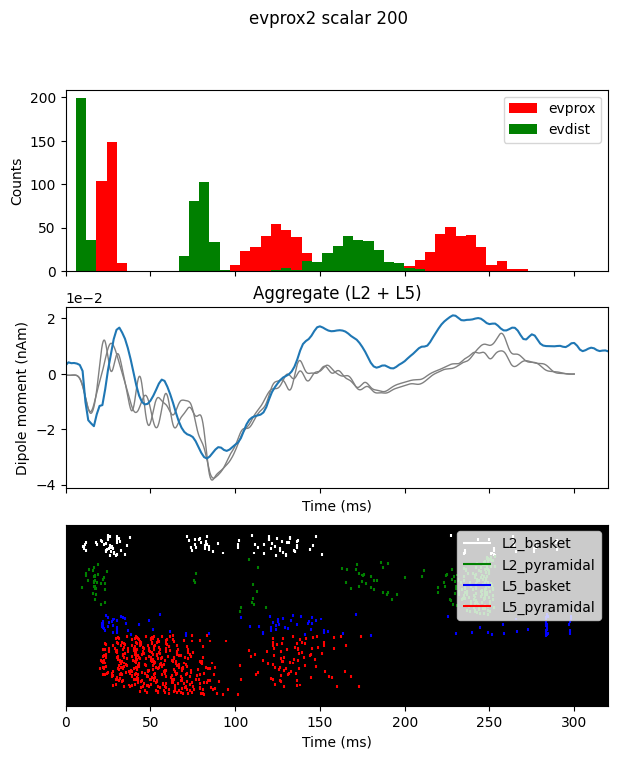

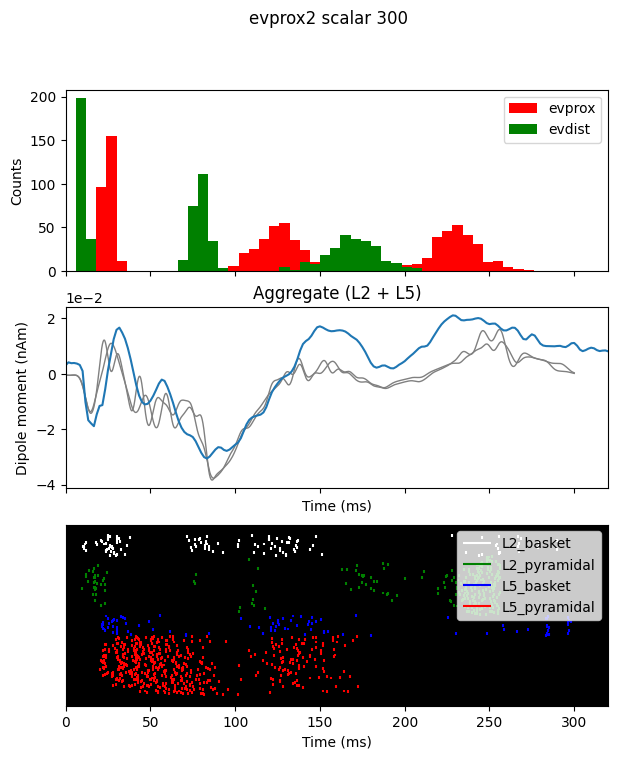

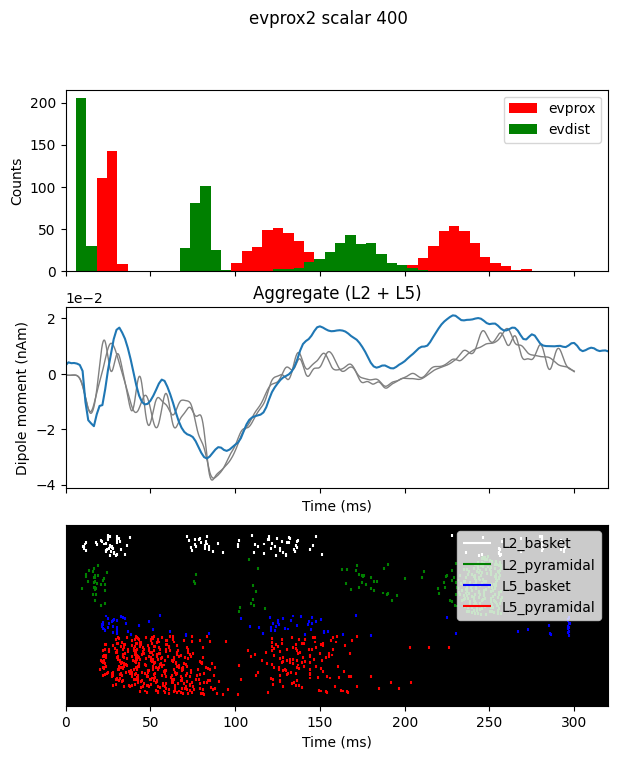

In [156]:
for i in range(len(increase_evprox2_dpl_smoothed_list)):
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7,8))

    increase_evprox_2_nets[i].cell_response.plot_spikes_hist(ax=axes[0], spike_types=['evprox', 'evdist'], trial_idx=0, show=False)

    plot_dipole(increase_evprox2_dpl_smoothed_list[i], ax = axes[1], layer='agg', show=False)
    axes[1].plot(data[0], np.array(data[1])*5)
    axes[1].set_xlim(0,320)

    increase_evprox_2_nets[i].cell_response.plot_spikes_raster(ax=axes[2], trial_idx=1, show=False)

    fig.suptitle(f'evprox2 scalar {prox2_scalars[i]}')